# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
import itertools as it
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
  
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 30 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
X_train_feats.shape

(49000, 175)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-8, 7.5e-8, 1e-7]
regularization_strengths = [5e5, 1e6, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
combinations, length = it.tee(it.product(learning_rates, regularization_strengths))
tune_length = len(list(length))
for i, (lr, rs) in enumerate(combinations):
    print('Iteration {}/{}'.format(i+1, tune_length))
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=200)
    y_preds = svm.predict(X_val_feats)
    acc = (y_preds == y_val).sum() / y_val.size
    print('Params -> lr: {}, reg: {}'.format(lr, rs))
    print('Score: {}'.format(acc))
    if best_val < acc:
        best_val = acc
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f'
          % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Iteration 1/9
Params -> lr: 5e-08, reg: 500000.0
Score: 0.147
Iteration 2/9
Params -> lr: 5e-08, reg: 1000000.0
Score: 0.43
Iteration 3/9
Params -> lr: 5e-08, reg: 5000000.0
Score: 0.386
Iteration 4/9
Params -> lr: 7.5e-08, reg: 500000.0
Score: 0.404
Iteration 5/9
Params -> lr: 7.5e-08, reg: 1000000.0
Score: 0.405
Iteration 6/9
Params -> lr: 7.5e-08, reg: 5000000.0
Score: 0.388
Iteration 7/9
Params -> lr: 1e-07, reg: 500000.0
Score: 0.42
Iteration 8/9
Params -> lr: 1e-07, reg: 1000000.0
Score: 0.41
Iteration 9/9
Params -> lr: 1e-07, reg: 5000000.0
Score: 0.395
best validation accuracy achieved during cross-validation: 0.430000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


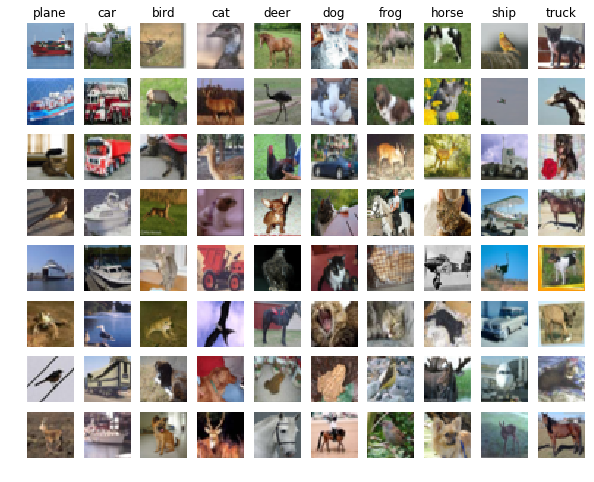

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

For most of images, yes. Misclassified ship pictures have blue background which has same color histogram as ground truth. Cars and trucks, cats and dots are misclassified due to similarity of their shapes (HOG). Wrong deer pics have a lot of green. Most surprising ones are horses and deers classified as cars. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
print(X_train_feats.shape)

(49000, 175)


In [18]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learns = [0.1, 0.2]
regs = [0.0001, 0.001]
niters = [500, 2000]
hiddens = [500, 1000]

combinations, length = it.tee(it.product(learns, regs, niters, hiddens))
tune_length = len(list(length))
best_val = -1
best_stats = None
for i, (lr, rs, ni, hid) in enumerate(combinations):
    print('Iteration {}/{}'.format(i+1, tune_length))
    net = TwoLayerNet(input_dim, hid, num_classes)
    stats = net.train(X_train_feats, y_train,
                      X_val_feats, y_val,
                      num_iters=ni,
                      batch_size=200,
                      learning_rate=lr,
                      learning_rate_decay=0.95,
                      reg=rs, verbose=False)
    
    y_preds = net.predict(X_val_feats)
    acc = (y_preds == y_val).mean()
    
    print('Params -> lr: {}, reg: {}, nit: {}, hid: {}'.format(lr, rs, ni, hid))
    print('Score: {}'.format(acc))
    
    if best_val < acc:
        best_val = acc
        best_net = net
        best_stats = stats
        best_params = {'lr': lr, 'rs': rs, 'ni': ni, 'hid': hid}
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Iteration 1/16
Params -> lr: 0.1, reg: 0.0001, nit: 500, hid: 500
Score: 0.461
Iteration 2/16
Params -> lr: 0.1, reg: 0.0001, nit: 500, hid: 1000
Score: 0.472
Iteration 3/16
Params -> lr: 0.1, reg: 0.0001, nit: 2000, hid: 500
Score: 0.541
Iteration 4/16
Params -> lr: 0.1, reg: 0.0001, nit: 2000, hid: 1000
Score: 0.54
Iteration 5/16
Params -> lr: 0.1, reg: 0.001, nit: 500, hid: 500
Score: 0.471
Iteration 6/16
Params -> lr: 0.1, reg: 0.001, nit: 500, hid: 1000
Score: 0.475
Iteration 7/16
Params -> lr: 0.1, reg: 0.001, nit: 2000, hid: 500
Score: 0.54
Iteration 8/16
Params -> lr: 0.1, reg: 0.001, nit: 2000, hid: 1000
Score: 0.542
Iteration 9/16
Params -> lr: 0.2, reg: 0.0001, nit: 500, hid: 500
Score: 0.522
Iteration 10/16
Params -> lr: 0.2, reg: 0.0001, nit: 500, hid: 1000
Score: 0.517
Iteration 11/16
Params -> lr: 0.2, reg: 0.0001, nit: 2000, hid: 500
Score: 0.594
Iteration 12/16
Params -> lr: 0.2, reg: 0.0001, nit: 2000, hid: 1000
Score: 0.575
Iteration 13/16
Params -> lr: 0.2, reg: 0.0

In [21]:
print('Best val score:', best_val)
print('Best params:', best_params)

Best val score: 0.594
Best params: {'lr': 0.2, 'rs': 0.0001, 'ni': 2000, 'hid': 500}


In [22]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.566


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

#### Many images are centered; lets extract same features from the center
It will make our classifiers to concern less about the background.

In [69]:
X_train.shape

(49000, 32, 32, 3)

In [59]:
crop_size = 16
sl = slice(crop_size - (crop_size+1)//2, crop_size + (crop_size+1)//2)

In [60]:
X_train_crop = X_train[:, sl, sl, :]
X_val_crop = X_val[:, sl, sl, :]
X_test_crop = X_test[:, sl, sl, :]

In [61]:
X_train_crop.shape, X_val_crop.shape, X_test_crop.shape

((49000, 16, 16, 3), (1000, 16, 16, 3), (1000, 16, 16, 3))

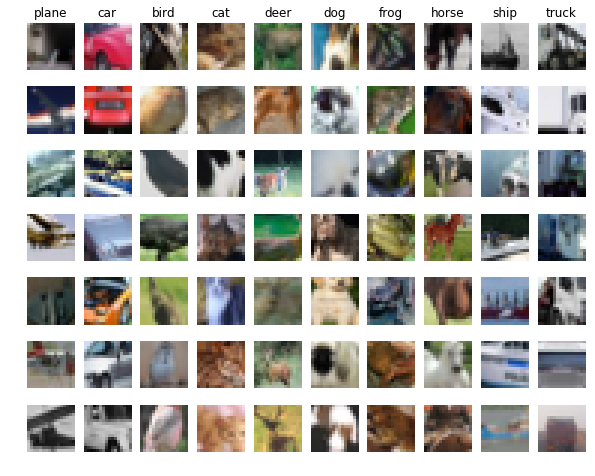

In [62]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_crop[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [63]:
num_color_bins = 30 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats_crop = extract_features(X_train_crop, feature_fns, verbose=True)
X_val_feats_crop = extract_features(X_val_crop, feature_fns)
X_test_feats_crop = extract_features(X_test_crop, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats_crop, axis=0, keepdims=True)
X_train_feats_crop -= mean_feat
X_val_feats_crop -= mean_feat
X_test_feats_crop -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats_crop, axis=0, keepdims=True)
X_train_feats_crop /= std_feat
X_val_feats_crop /= std_feat
X_test_feats_crop /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats_crop = np.hstack([X_train_feats_crop, np.ones((X_train_feats_crop.shape[0], 1))])
X_val_feats_crop = np.hstack([X_val_feats_crop, np.ones((X_val_feats_crop.shape[0], 1))])
X_test_feats_crop = np.hstack([X_test_feats_crop, np.ones((X_test_feats_crop.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [64]:
X_train_feats_crop.shape, X_train_feats.shape

((49000, 67), (49000, 175))

In [65]:
# Join old and new features
X_train_new = np.hstack((X_train_feats, X_train_feats_crop))
X_val_new = np.hstack((X_val_feats, X_val_feats_crop))
X_test_new = np.hstack((X_test_feats, X_test_feats_crop))

In [66]:
X_train_new.shape

(49000, 242)

#### SVM

In [74]:
from cs231n.classifiers import LinearSVM

learning_rates = [5e-8, 7.5e-8, 1e-7, 2.5e-7, 5e-7, 7.5e-7]
regularization_strengths = [5e5, 7.5e5, 1e6, 2.5e7, 5e6]

results = {}
best_val = -1
best_svm = None

combinations, length = it.tee(it.product(learning_rates, regularization_strengths))
tune_length = len(list(length))
for i, (lr, rs) in enumerate(combinations):
    print('Iteration {}/{}'.format(i+1, tune_length))
    svm = LinearSVM()
    svm.train(X_train_new, y_train, learning_rate=lr, reg=rs, num_iters=200)
    y_preds = svm.predict(X_val_new)
    acc = (y_preds == y_val).sum() / y_val.size
    print('Params -> lr: {}, reg: {}'.format(lr, rs))
    print('Score: {}'.format(acc))
    if best_val < acc:
        best_val = acc

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f'
          % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Iteration 1/30
Params -> lr: 5e-08, reg: 500000.0
Score: 0.132
Iteration 2/30
Params -> lr: 5e-08, reg: 750000.0
Score: 0.344
Iteration 3/30
Params -> lr: 5e-08, reg: 1000000.0
Score: 0.435
Iteration 4/30
Params -> lr: 5e-08, reg: 25000000.0
Score: 0.328
Iteration 5/30
Params -> lr: 5e-08, reg: 5000000.0
Score: 0.399
Iteration 6/30
Params -> lr: 7.5e-08, reg: 500000.0
Score: 0.404
Iteration 7/30
Params -> lr: 7.5e-08, reg: 750000.0
Score: 0.438
Iteration 8/30
Params -> lr: 7.5e-08, reg: 1000000.0
Score: 0.436
Iteration 9/30
Params -> lr: 7.5e-08, reg: 25000000.0
Score: 0.233
Iteration 10/30
Params -> lr: 7.5e-08, reg: 5000000.0
Score: 0.415
Iteration 11/30
Params -> lr: 1e-07, reg: 500000.0
Score: 0.446
Iteration 12/30
Params -> lr: 1e-07, reg: 750000.0
Score: 0.429
Iteration 13/30
Params -> lr: 1e-07, reg: 1000000.0
Score: 0.433
Iteration 14/30
Params -> lr: 1e-07, reg: 25000000.0
Score: 0.103
Iteration 15/30
Params -> lr: 1e-07, reg: 5000000.0
Score: 0.373
Iteration 16/30
Params -> l

D:\Courses\cs231n\assignments\assignment1\cs231n\classifiers\linear_svm.py:86: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(np.square(W))
D:\Courses\cs231n\assignments\assignment1\cs231n\classifiers\linear_svm.py:86: RuntimeWarning: overflow encountered in square
  loss += 0.5 * reg * np.sum(np.square(W))


Params -> lr: 5e-07, reg: 25000000.0
Score: 0.103
Iteration 25/30
Params -> lr: 5e-07, reg: 5000000.0
Score: 0.104
Iteration 26/30
Params -> lr: 7.5e-07, reg: 500000.0
Score: 0.391
Iteration 27/30
Params -> lr: 7.5e-07, reg: 750000.0
Score: 0.368
Iteration 28/30
Params -> lr: 7.5e-07, reg: 1000000.0
Score: 0.333
Iteration 29/30
Params -> lr: 7.5e-07, reg: 25000000.0
Score: 0.095
Iteration 30/30
Params -> lr: 7.5e-07, reg: 5000000.0
Score: 0.127
best validation accuracy achieved during cross-validation: 0.446000


In [75]:
print('Best val score:', best_val)

Best val score: 0.446


In [68]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_new)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


#### NN

In [ ]:
import scipy

In [70]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_new.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

learns = [0.1, 0.2]
regs = [0.0001, 0.001]
niters = [500, 2000]
hiddens = [500, 1000]

combinations, length = it.tee(it.product(learns, regs, niters, hiddens))
tune_length = len(list(length))
best_val = -1
best_stats = None
for i, (lr, rs, ni, hid) in enumerate(combinations):
    print('Iteration {}/{}'.format(i+1, tune_length))
    net = TwoLayerNet(input_dim, hid, num_classes)
    stats = net.train(X_train_new, y_train,
                      X_val_new, y_val,
                      num_iters=ni,
                      batch_size=200,
                      learning_rate=lr,
                      learning_rate_decay=0.95,
                      reg=rs, verbose=False)
    
    y_preds = net.predict(X_val_new)
    acc = (y_preds == y_val).mean()
    
    print('Params -> lr: {}, reg: {}, nit: {}, hid: {}'.format(lr, rs, ni, hid))
    print('Score: {}'.format(acc))
    
    if best_val < acc:
        best_val = acc
        best_net = net
        best_stats = stats
        best_params = {'lr': lr, 'rs': rs, 'ni': ni, 'hid': hid}


Iteration 1/16
Params -> lr: 0.1, reg: 0.0001, nit: 500, hid: 500
Score: 0.503
Iteration 2/16
Params -> lr: 0.1, reg: 0.0001, nit: 500, hid: 1000
Score: 0.508
Iteration 3/16
Params -> lr: 0.1, reg: 0.0001, nit: 2000, hid: 500
Score: 0.572
Iteration 4/16
Params -> lr: 0.1, reg: 0.0001, nit: 2000, hid: 1000
Score: 0.566
Iteration 5/16
Params -> lr: 0.1, reg: 0.001, nit: 500, hid: 500
Score: 0.497
Iteration 6/16
Params -> lr: 0.1, reg: 0.001, nit: 500, hid: 1000
Score: 0.501
Iteration 7/16
Params -> lr: 0.1, reg: 0.001, nit: 2000, hid: 500
Score: 0.569
Iteration 8/16
Params -> lr: 0.1, reg: 0.001, nit: 2000, hid: 1000
Score: 0.568
Iteration 9/16
Params -> lr: 0.2, reg: 0.0001, nit: 500, hid: 500
Score: 0.54
Iteration 10/16
Params -> lr: 0.2, reg: 0.0001, nit: 500, hid: 1000
Score: 0.536
Iteration 11/16
Params -> lr: 0.2, reg: 0.0001, nit: 2000, hid: 500
Score: 0.62
Iteration 12/16
Params -> lr: 0.2, reg: 0.0001, nit: 2000, hid: 1000
Score: 0.595
Iteration 13/16
Params -> lr: 0.2, reg: 0.0

In [71]:
print('Best val score:', best_val)
print('Best params:', best_params)

Best val score: 0.62
Best params: {'lr': 0.2, 'rs': 0.0001, 'ni': 2000, 'hid': 500}


In [73]:
test_acc = (best_net.predict(X_test_new) == y_test).mean()
print(test_acc)

0.589


Now our neural network perform slightly better with the same parameters! (3% gain on val set, 2% on test)

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!